## CNN pour tout station

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers ,optimizers,models,regularizers
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from codecarbon import EmissionsTracker
import logging

code carbon

In [5]:
tracker = EmissionsTracker(
    project_name="cnn_window_glissant",
    log_level=logging.INFO,
    output_file="model_cnn_window_glissant.csv",
    output_dir='../emissions/',
    save_to_file=True,
    measure_power_secs=60,
    allow_multiple_runs=True 
)

[codecarbon WARNING @ 00:21:44] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:21:44] [setup] RAM Tracking...
[codecarbon INFO @ 00:21:44] [setup] CPU Tracking...
[codecarbon WARNING @ 00:21:44] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 00:21:47] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
[codecarbon INFO @ 00:21:47] [setup] GPU Tracking...
[codecarbon INFO @ 00:21:47] No GPU found.
[codecarbon INFO @ 00:21:47] >>> Tracker's metadata:
[codecarbon INFO @ 00:21:47]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 00:21:47]   Python version: 3.9.6
[codecarbon INFO @ 00:21:47]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 00:21:47]   Available RAM : 15.852 GB
[codecarbon INFO @ 00:21:47]   CPU count: 8
[codecarbon INFO @ 00:21:47]   CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80G

In [6]:
file_path = '../data/merged_all_bikes_weather_events.csv'
data = pd.read_csv(file_path)
data['timestamp'] = pd.to_datetime(data['timestamp']).astype('int64') 
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data=data.sort_values('timestamp')
print(data.columns.to_list())
feature_to_normaliser=['bike_stands','available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events']
other_features = [col for col in data.columns if col not in feature_to_normaliser]
new_column_order=feature_to_normaliser+other_features
data=data[new_column_order]
print(data.columns.to_list())
num_features_to_normalize=len(feature_to_normaliser)

['timestamp', 'number', 'status', 'available_bike_stands', 'available_bikes', 'bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'wind_speed', 'counter_events', 'day_of_week', 'is_weekend']
['bike_stands', 'available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events', 'timestamp', 'number', 'status', 'available_bikes', 'is_rainy', 'day_of_week', 'is_weekend']


Normaliser

In [7]:
### verifier ordonne
data[:5]

bike_stands  available_bike_stands  visibility_distance  \
1036302           13                      1              10000.0   
5656              13                     11              10000.0   
592046            13                     11              10000.0   
867329            17                      9              10000.0   
867328            20                     19              10000.0   

         current_temperature  feels_like_temperature  wind_speed  \
1036302                 6.99                    6.17        5.54   
5656                    6.99                    6.17        5.54   
592046                  6.99                    6.17        5.54   
867329                  6.99                    6.17        5.54   
867328                  6.99                    6.17        5.54   

         counter_events            timestamp  number  status  available_bikes  \
1036302               0  1733940000000000000     342       1               12   
5656                  0  1733940000000000000     387       1                0   
592046                1  1733940000000000000     302       1                1   
867329                0  1733940000000000000     214       1                8   
867328                0  1733940000000000000     253       1                1   

         is_rainy  day_of_week  is_weekend  
1036302       0.0            2           0  
5656          0.0            2           0  
592046        0.0            2           0  
867329        0.0            2           0  
867328        0.0            2           0

In [8]:
X = data.drop(columns=['available_bikes']).values  
y = data['available_bikes'].values 
## test et train
split_index = int(0.8 * len(X))  
X_train_raw, X_test_raw = X[:split_index], X[split_index:]
y_train_raw, y_test_raw = y[:split_index], y[split_index:]
scaler_X = StandardScaler()
X_train_to_normalize = X_train_raw[:, :num_features_to_normalize]
X_train_not_to_normalize = X_train_raw[:, num_features_to_normalize:]
X_train_feature_normalized = scaler_X.fit_transform(X_train_to_normalize)

X_test_to_normalize = X_test_raw[:, :num_features_to_normalize]
X_test_not_to_normalize = X_test_raw[:, num_features_to_normalize:]
X_test_to_feature_normalized = scaler_X.transform(X_test_to_normalize)

X_train = np.hstack([X_train_feature_normalized, X_train_not_to_normalize])
X_test = np.hstack([X_test_to_feature_normalized, X_test_not_to_normalize])

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()
print("\n x train shape:",X_train.shape)
print("\n x test shape:",X_test.shape)
print("\n y train shape:",y_train.shape)
print("\n y test shape:",y_test.shape)


 x train shape: (950319, 13)

 x test shape: (237580, 13)

 y train shape: (950319,)

 y test shape: (237580,)


window glissant

In [9]:
station_column_index = list(data.drop(columns='available_bikes').columns).index('number')

print(station_column_index)
station_ids = X[:, station_column_index]
print(station_ids)
unique_stations = np.unique(station_ids)
print(len(unique_stations))

8
[342. 387. 302. ... 396. 395.  57.]
382


In [11]:
def create_sliding_window_grouped(X, y, station_ids, time_steps):
    X_seq_all, y_seq_all, station_seq_all = [], [], []
    unique_stations = np.unique(station_ids)

    for station in unique_stations:
        station_indices = np.where(station_ids == station)[0]
        X_station = X[station_indices]
        y_station = y[station_indices]
        for i in range(len(X_station) - time_steps):
            X_window = np.hstack([X_station[i:i + time_steps], y_station[i:i + time_steps].reshape(-1, 1)])
            X_seq_all.append(X_window)
            y_seq_all.append(y_station[i + time_steps])
            station_seq_all.append(station)

    return np.array(X_seq_all), np.array(y_seq_all), np.array(station_seq_all)
time_steps=24
X_train_seq, y_train_seq, station_train_seq = create_sliding_window_grouped(X_train, y_train, station_ids[:split_index], time_steps)
X_test_seq, y_test_seq, station_test_seq = create_sliding_window_grouped(X_test, y_test, station_ids[split_index:], time_steps)

print("\ntrain data:")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("station_train_seq shape:", station_train_seq.shape)

print("\ntest data:")
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)
print("station_test_seq shape:", station_test_seq.shape)


train data:
X_train_seq shape: (941165, 24, 14)
y_train_seq shape: (941165,)
station_train_seq shape: (941165,)

test data:
X_test_seq shape: (228436, 24, 14)
y_test_seq shape: (228436,)
station_test_seq shape: (228436,)


model cnn

verifier data tranning

In [30]:
print(data.drop(columns='available_bikes').columns.to_list())
print(X_train_seq[1])
print(y_train_seq[1])
print(station_train_seq[1])

['bike_stands', 'available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events', 'timestamp', 'number', 'status', 'is_rainy', 'day_of_week', 'is_weekend']
[[ 1.72202353e-01 -1.03536664e+00  6.01042690e-01 -5.99491337e-02
   1.07119318e-01 -6.82358561e-01  2.39246223e+00  1.73394090e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  1.72959482e+00]
 [ 1.72202353e-01 -8.77472694e-01  6.01042690e-01 -1.34252842e-01
  -1.50572189e-02 -6.29059375e-01  2.39246223e+00  1.73394180e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  1.31811629e+00]
 [ 1.72202353e-01 -5.61684805e-01  6.01042690e-01 -2.08556550e-01
  -1.37233756e-01 -5.75760190e-01  2.39246223e+00  1.73394270e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  9.06637764e-01]
 [ 1.72202353e-01 -2.45896916e-01  6.01042690e-01 -2.82860258e-01
  -2.59410293e-0

In [31]:
model = models.Sequential()
model.add(layers.Conv1D(filters=6, kernel_size=1, activation='relu',
                 input_shape=(X_train_seq.shape[1],X_train_seq.shape[2]), padding='same'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=6, kernel_size=8, activation='relu',padding='same'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=1))
model.compile(optimizer='adam', loss='mse')
model.summary()

d:\CODE\code_python\integre\cnn\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 8, 6)           │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 4, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 4, 6)           │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 2, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397 (1.55 KB)

 Trainable params: 397 (1.55 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
val_size = int(0.6 * len(X_test_seq))
X_test_seq, X_val = X_test_seq[:val_size], X_test_seq[val_size:]
y_test_seq, y_val = y_test_seq[:val_size], y_test_seq[val_size:]
print("\ntrain data:")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)

print("\nval data:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\ntest data:")
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)


train data:
X_train_seq shape: (947263, 8, 14)
y_train_seq shape: (947263,)

val data:
X_val shape: (93813, 8, 14)
y_val shape: (93813,)

test data:
X_test_seq shape: (140719, 8, 14)
y_test_seq shape: (140719,)


In [ ]:

from tensorflow.keras import callbacks
print("Training the model...")
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        min_delta=0.001
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]
tracker.start()
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    shuffle=False,
    callbacks=[callbacks] 
)

tracker.stop()


Training the model...


Epoch 1/10
 1432/14801 ━━━━━━━━━━━━━━━━━━━━ 6:51 31ms/step - loss: nan

[codecarbon INFO @ 00:15:48] Energy consumed for RAM : 0.000099 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 00:15:48] Energy consumed for all CPUs : 0.000234 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 00:15:48] 0.000333 kWh of electricity used since the beginning.


 2184/14801 ━━━━━━━━━━━━━━━━━━━━ 7:29 36ms/step - loss: nan

KeyboardInterrupt: 

[codecarbon INFO @ 00:16:48] Energy consumed for RAM : 0.000198 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 00:16:48] Energy consumed for all CPUs : 0.000467 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 00:16:48] 0.000665 kWh of electricity used since the beginning.


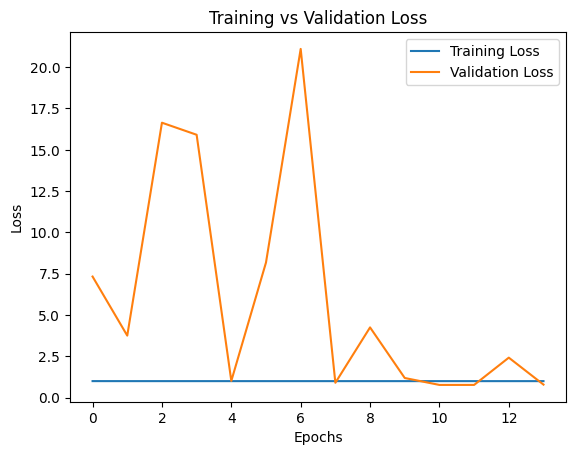

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [21]:
def taux_correct_predictions(y_test,y_pred,tolerance):
    correct_predictions = np.abs(y_test - y_pred) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  
    print(f"Le taux de précision correctes de test avec tolerance={tolerance}: {accuracy:.2f}%")
predictions = model.predict(X_test_seq)
predictions = np.round(predictions).astype(int)
# Calcul des métriques pour l'ensemble de test
mse = mean_squared_error(y_test_seq, predictions)
mae = mean_absolute_error(y_test_seq, predictions)
r2 = r2_score(y_test_seq, predictions)
y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

taux_correct_predictions(y_test,predictions,0)
taux_correct_predictions(y_test,predictions,1)
taux_correct_predictions(y_test,predictions,2)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

2570/2570 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step
Le taux de précision correctes de test avec tolerance=0: 0.00%
Le taux de précision correctes de test avec tolerance=1: 0.00%
Le taux de précision correctes de test avec tolerance=2: 0.00%
MSE: 85070591730234615865843651857942052864.0000, MAE: 9223372036854775808.0000, R²: -64763528680487651323072987090005262336.0000


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11764\1978480126.py:6: RuntimeWarning: invalid value encountered in cast
  predictions = np.round(predictions).astype(int)


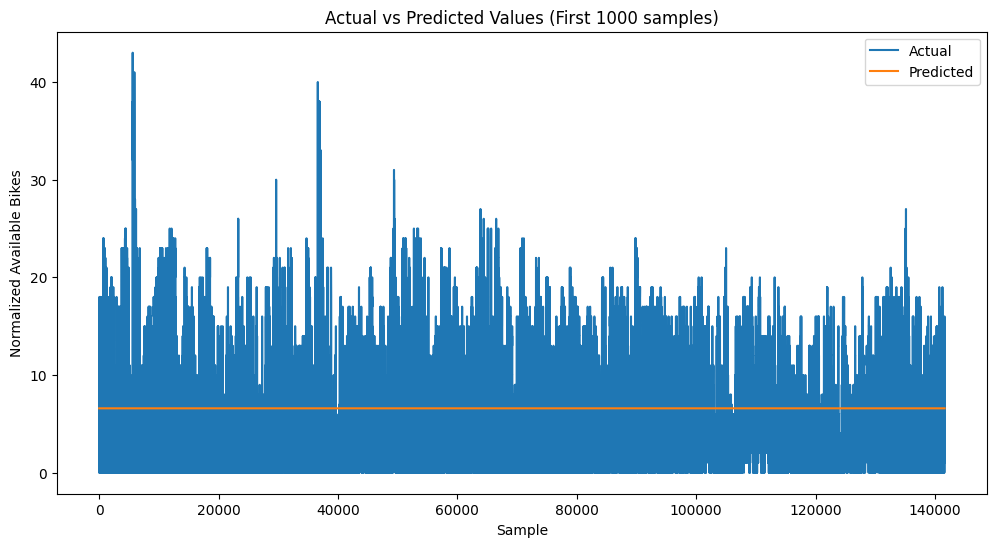

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values (First 1000 samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Available Bikes')
plt.legend()
plt.show()